## Data Preparation

In [16]:
import os
import random
import shutil
import sys
import time

# Changing present working directory to the project directory
os.chdir('/home/anushka/Documents/Deep  Learning Projects/Flower classifier')

# Define class labels and datasets
class_labels=['rathmal','miniimal','orchid']
datasets=['train','test']

## copy data from source to project directory
# base direcotry of dataset
base_dir="/home/anushka/Pictures/OpenCamera"
output_dir="/home/anushka/Documents/Deep  Learning Projects/Flower classifier"

# define train ratio\
train_ratio=0.8

In [17]:
# clear train, test directories if they exist
for dataset in datasets:
    directory_path = os.path.join(output_dir, dataset)
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)


In [18]:
# move images to respective folders

for class_label in class_labels:
    source_dir=os.path.join(base_dir,class_label)
    all_files=os.listdir(source_dir) # list of all files in the source ditectory
    random.shuffle(all_files)


    num_train=int(train_ratio*len(all_files))
    train_files=all_files[:num_train]
    test_files=all_files[num_train:]

    # create train and test directories
    for dataset in datasets:
        dataset_dest=os.path.join(output_dir,dataset,class_label)
        os.makedirs(dataset_dest,exist_ok=True)

        # copy files
        if dataset=='train':
            for filename in train_files:
                shutil.copy(os.path.join(source_dir,filename),dataset_dest)
            
        else:
            for filename in test_files:
                shutil.copy(os.path.join(source_dir,filename),dataset_dest)
            


## Class Building

In [19]:
import numpy as np
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Normalize
from torch.optim.lr_scheduler import LambdaLR

import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.notebook import tqdm

plt.style.use('fivethirtyeight')


In [30]:
# LR range test
def make_lr_fn(start_lr,end_lr,num_iter,step_mode='exp'):
    if step_mode=='linear':
        factor=(end_lr/start_lr-1)/num_iter
        # mutiplying factor given current iteration number
        def lr_fn(iteration):
            return 1+iteration*factor
        
    else:
        factor=(np.log(end_lr)-np.log(start_lr))/num_iter
        # multiplying factor given current iteration number
        def lr_fn(iteration):
            return np.exp(factor)**iteration
        
    return lr_fn

In [118]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        self.scheduler = None
        self.is_batch_lr_scheduler = False
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.learning_rates = []
        self.total_epochs = 0
        
        self.visualization = {}
        self.handles = {}

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()
        
    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None
            
        n_batches = len(data_loader)
        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for i, (x_batch, y_batch) in enumerate(data_loader):
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)
            
            if not validation:
                self._mini_batch_schedulers(i / n_batches)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass
        
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in tqdm(range(n_epochs)):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            self._epoch_schedulers(val_loss)
                        
            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

    def count_parameters(self):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)
    
    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title('{} #{}'.format(title, j), fontsize=12)
            ax.set_ylabel(
                '{}\n{}x{}'.format(layer_name, *np.atleast_2d(image).shape), 
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else '\nLabel: {}'.format(y[j])
            xlabel2 = '' if yhat is None else '\nPredicted: {}'.format(yhat[j])
            xlabel = '{}{}'.format(xlabel1, xlabel2)
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray', 
                vmin=minv, 
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # The weights have channels_out (filter), channels_in, H, W shape
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels, figsize=size)
                axes = np.atleast_2d(axes).reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):    
                    StepByStep._visualize_tensors(
                        axes[i, :], 
                        weights[i], 
                        layer_name='Filter #{}'.format(i), 
                        title='Channel' if (i == 0) else None
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return
    
    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}
        
        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = list(filter(lambda l: l in self.visualization.keys(), layers))
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1 for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images, figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                StepByStep._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y, 
                    yhat, 
                    layer_name=layers[i] if is_vector else '{}\nfil#{}'.format(layers[i], row-start_row),
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes 
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:        
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax, 
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
               isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (torch.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)
    
    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel 
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = StepByStep.loader_apply(loader, StepByStep.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)
                        
    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()), 
                           'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig
    
    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def capture_gradients(self, layers_to_hook):
        if not isinstance(layers_to_hook, list):
            layers_to_hook = [layers_to_hook]

        modules = list(self.model.named_modules())
        self._gradients = {}

        def make_log_fn(name, parm_id):
            def log_fn(grad):
                self._gradients[name][parm_id].append(grad.tolist())
                return
            return log_fn

        for name, layer in self.model.named_modules():
            if name in layers_to_hook:
                self._gradients.update({name: {}})
                for parm_id, p in layer.named_parameters():
                    if p.requires_grad:
                        self._gradients[name].update({parm_id: []})
                        log_fn = make_log_fn(name, parm_id)
                        self.handles[f'{name}.{parm_id}.grad'] = p.register_hook(log_fn)
        return

    def capture_parameters(self, layers_to_hook):
        if not isinstance(layers_to_hook, list):
            layers_to_hook = [layers_to_hook]

        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules}

        self._parameters = {}

        for name, layer in modules:
            if name in layers_to_hook:
                self._parameters.update({name: {}})
                for parm_id, p in layer.named_parameters():
                    self._parameters[name].update({parm_id: []})

        def fw_hook_fn(layer, inputs, outputs):
            name = layer_names[layer]
            for parm_id, parameter in layer.named_parameters():
                self._parameters[name][parm_id].append(parameter.tolist())

        self.attach_hooks(layers_to_hook, fw_hook_fn)
        return
    
    def set_lr_scheduler(self, scheduler):
        # Makes sure the scheduler in the argument is assigned to the
        # optimizer we're using in this class
        if scheduler.optimizer == self.optimizer:
            self.scheduler = scheduler
            if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or
                isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or
                isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts)):
                self.is_batch_lr_scheduler = True
            else:
                self.is_batch_lr_scheduler = False

    def _epoch_schedulers(self, val_loss):
        if self.scheduler:
            if not self.is_batch_lr_scheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

                current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
                self.learning_rates.append(current_lr)
        
    def _mini_batch_schedulers(self, frac_epoch):
        if self.scheduler:
            if self.is_batch_lr_scheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts):
                    self.scheduler.step(self.total_epochs + frac_epoch)
                else:
                    self.scheduler.step()

                current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
                self.learning_rates.append(current_lr)

## Building The model

### Imports

In [40]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR


### Data Preparation

#### Standardization

In [108]:
temp_transform=Compose([Resize((64,64)),ToTensor()])
temp_dataset=ImageFolder(root='train',transform=temp_transform)

In [112]:
temp_dataset[0][0].shape

torch.Size([3, 64, 64])

In [113]:
temp_loader=DataLoader(temp_dataset,batch_size=64,shuffle=True)

In [142]:
first_images,first_labels=next(iter(temp_loader))
StepByStep.statistics_per_channel(first_images,first_labels)

tensor([[64.0000, 64.0000, 64.0000],
        [28.1077, 25.2919, 19.8645],
        [13.0618, 10.1422, 11.6410]])

In [150]:
results=StepByStep.loader_apply(temp_loader,StepByStep.statistics_per_channel)
results

tensor([[1324.0000, 1324.0000, 1324.0000],
        [ 578.7628,  529.1880,  401.8793],
        [ 273.8475,  214.6406,  245.8830]])

In [154]:
normalizer=StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.4371, 0.3997, 0.3035]), std=tensor([0.2068, 0.1621, 0.1857]))

### Buidling the Real Dataset

In [155]:
composer=Compose([Resize((64,64)),ToTensor(),normalizer])

train_data=ImageFolder(root='train',transform=composer)
val_data=ImageFolder(root='test',transform=composer)

# Builds a loader of each set
train_loader=DataLoader(dataset=train_data,batch_size=64,shuffle=True)
val_loader=DataLoader(dataset=val_data,batch_size=64)

Visualize the first 50 samples from mini batch

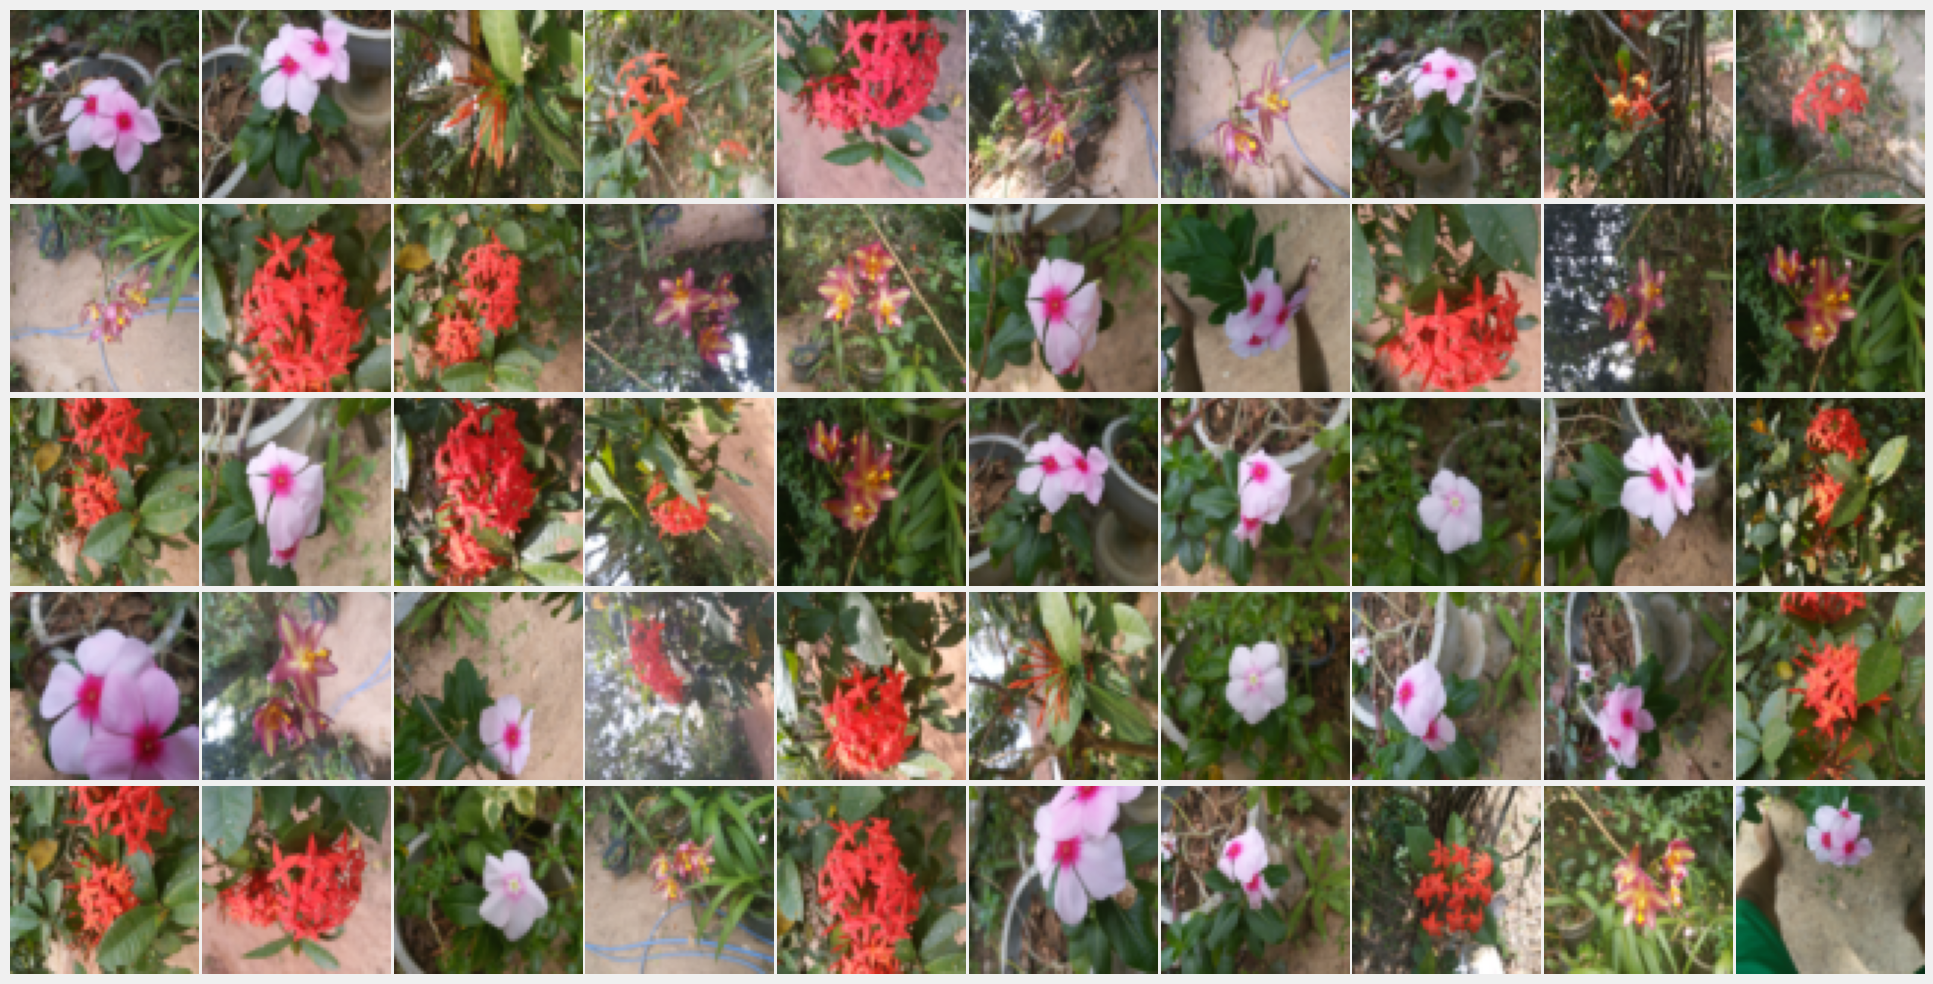

In [149]:
import matplotlib.pyplot as plt

# Create a figure and grid of subplots
fig, axes = plt.subplots(5, 10, figsize=(22, 12))

# Shrink the space between subplots
plt.subplots_adjust(wspace=0.02, hspace=-0.01)

for i in range(50):
    # Convert the tensor to a PIL image
    pil_image = ToPILImage()(first_images[i])

    # Display the image
    axes[i//10, i%10].imshow(pil_image)
    axes[i//10, i%10].axis('off')


plt.show()


### Model Architecture

In [168]:
class CNN(nn.Module):
    def __init__(self,n_feature,p=0.0):
        super(CNN,self).__init__()
        self.n_feature=n_feature
        self.p=p

        # creates convolutional layers
        self.conv1=nn.Conv2d(in_channels=3,out_channels=self.n_feature,kernel_size=6)
        self.conv2=nn.Conv2d(in_channels=20,out_channels=self.n_feature,kernel_size=6)
        # creates linear layers
        self.fc1=nn.Linear(in_features=n_feature*12*12,out_features=120)
        self.fc2=nn.Linear(in_features=120,out_features=3)
        # creates dropout layers
        self.drop=nn.Dropout(self.p)

    # featurizer
    def featurizer(self,x):
        # first convolutional block
        # 3@64x64 -> 20@59x59 -> 20@29x29
        x=self.conv1(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2)

        # second convolutional block
        # 20@29x29 -> 20@24x24 -> 20@12x12
        x=self.conv2(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2)
        x=nn.Flatten()(x)
        return x

    # classifier
    def classifier(self,x):
        # Hidden layer
        # 20x12x12 -> 120
        if self.p>0.0:
            x=self.drop(x)
        x=self.fc1(x)
        x=F.relu(x)

        # Output layer
        # 120 -> 3
        if self.p>0.0:
            x=self.drop(x)
        x=self.fc2(x)
        return x
    
    def forward(self,x):
        x=self.featurizer(x)
        x=self.classifier(x)
        return x



### Model configuration


In [171]:
torch.manual_seed(13)
model_cnn=CNN(n_feature=20,p=0.3)
multi_loss_fn=nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2=optim.Adam(params=model_cnn.parameters(),lr=0.01)


### Model Training

In [172]:
sbs_cnn=StepByStep(model_cnn,multi_loss_fn,optimizer_cnn2)
sbs_cnn.set_loaders(train_loader,val_loader)
sbs_cnn.train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

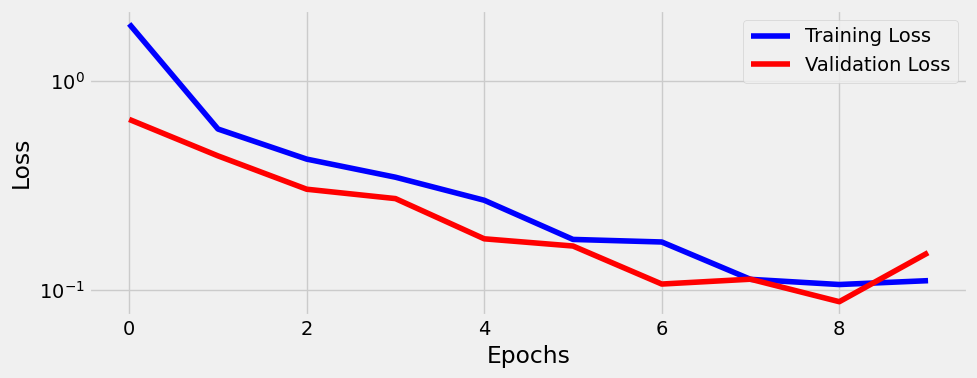

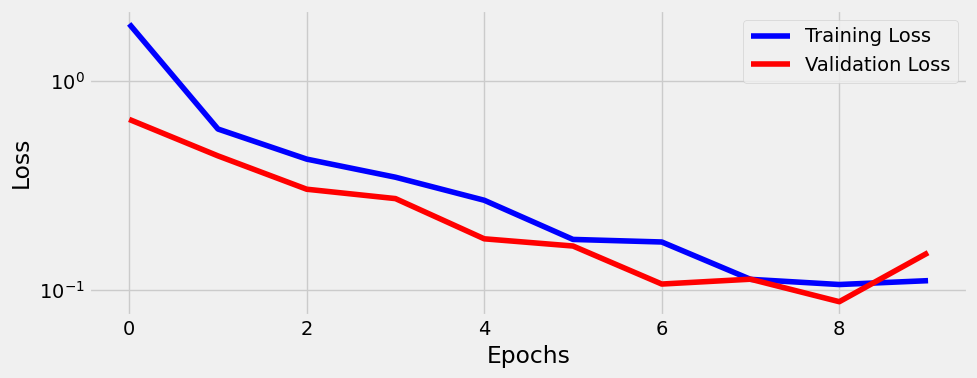

In [173]:
sbs_cnn.plot_losses()

In [174]:
StepByStep.loader_apply(val_loader, sbs_cnn.correct)

tensor([[126, 127],
        [ 67,  74],
        [126, 131]])

***Code will be moved to kaggle kernel for experimenting...***